# Step 1: Compression and Vectorization of Songs

References: 

https://github.com/shubham3121/music-generation-using-rnn 

https://www.hackerearth.com/blog/developers/jazz-music-using-deep-learning/

https://pyguitarpro.readthedocs.io/en/stable/index.html

## Imports

In [1]:
from glob import glob
import guitarpro
from guitarpro import *
from matplotlib import pyplot as plt
import numpy as np
import os
import pickle
from tqdm import tqdm

from keras.utils import np_utils

from _Compressor import compress_track

## Choose Songs (Make sure to convert to 4/4 before running)

In [2]:
# Choose all songs
# songs = glob('*.gp*')

# Choose a certain cohort of songs

'''
filenames = glob('pantera-*.gp*') + \
            glob('dream_theater-*.gp*')
'''
#filenames = ['korn-freak_on_a_leash.gp5']
#filenames = ['metallica-master_of_puppets.gp5']
#filenames = ['korn-blind.gp5']
#filenames = ['korn-falling_away_from_me.gp5']

#filenames = glob('metallica-*.gp*')

#filenames = glob('pantera-*.gp*')
filenames = [file for file in glob('*.gp*') if file[0] != '_']
#filenames

In [3]:
track_collections = []

# Debugging variables
track_names = []

for filename in tqdm(filenames):
    tracks = []
    
    song = guitarpro.parse(filename)
    
    for track in song.tracks:
        if track.isPercussionTrack:
            continue
        
        tracks.append(track)
        
    track_collections.append(tracks)
    track_names.append(filename)
        

print(f'Number of songs: {len(track_collections)}')

#[print(track.name) for track in tracks]

100%|██████████| 73/73 [01:15<00:00,  1.03s/it]

Number of songs: 73


## Song Compression

In [4]:
song_measures = []

num_rest_measures = 0

for song in tqdm(track_collections):
    
    measures = []
    
    for track in song:

        compressed_track = compress_track(track)

        # Ignore the current track if it only contains rests.
        if all(all(beat[0] == 'rest' for beat in measure) for measure in compressed_track):
            continue

        # Add each beat's note to the notes list.
        for measure in compressed_track:

            # Skip measures that are only rests or tied notes.
            if all(beat[0] == 'rest' or beat[0] == 'tied' for beat in measure):
                num_rest_measures += 1
                continue

            measures.append(measure)
            
    song_measures.append(measures)

100%|██████████| 73/73 [00:10<00:00,  6.73it/s]


#### Extracting most frequent sequences of 1 measure

In [5]:
#PERCENT_TOP_MEASURES_TO_KEEP = 0.1
NUM_TOP_MEASURES_TO_KEEP = 20

beats_song = []

#nums = []

#for s_i, measures in tqdm(enumerate(song_measures)):
for s_i, measures in enumerate(song_measures):
    
    frequent_measures, counts = np.unique(measures, return_counts=True)

    #num_rhythms = int(len(counts) * PERCENT_TOP_MEASURES_TO_KEEP)
    num_rhythms = min(len(counts), NUM_TOP_MEASURES_TO_KEEP)
    
    idx_most_common = np.argpartition(counts, -num_rhythms)[-num_rhythms:]
    measures_most_common = frequent_measures[idx_most_common]

    beats_song.extend(measures_most_common)
    
    #print(track_names[s_i], '\t\t', num_rhythms)
    #nums.append(num_rhythms)

C:\Users\josue\anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [6]:
from _Decompressor import decompress_track

MIDI  = {str(GuitarString(number=0, value=val)) : val for val in range(128)}

# Standard tuning
tuning = {1: MIDI['E4'],
          2: MIDI['B3'],
          3: MIDI['G3'],
          4: MIDI['D3'],
          5: MIDI['A2'],
          6: MIDI['E2']}

# Save beats to a .gp5 file.
new_song = decompress_track(beats_song, tuning)

guitarpro.write(new_song, '_beats.gp5')
print('Finished')

Finished


## Converting a measure into a beatmap

In [7]:
def get_beatmap(measure):
    REST = 0
    NOTE_TIED = 1
    NOTE_START = 2


    beatmap = np.zeros(32)
    idx = 0

    for b_i, beat in enumerate(measure):
        # Make sure that assigning to beatmap[i] does not occur for i >= 32.
        if idx >= 32:
            break


        #print(b_i, beat)

        num_thirty_seconds = int((32 // beat[1]) * (1 + 0.5 * beat[2])) // 1

        if beat[0] == 'rest':
            idx += num_thirty_seconds
            continue


        beatmap[idx] = NOTE_TIED if beat[0] == 'tied' else NOTE_START
        idx += 1

        upper_idx = min(32, idx + num_thirty_seconds - 1)


        beatmap[idx:upper_idx] = NOTE_TIED
        idx = upper_idx
        
    return beatmap

In [8]:
from matplotlib import pyplot as plt


def plot_beatmap(beatmap):
    plt.imshow(np.vstack([beatmap for _ in range(10)]))
    plt.xticks(np.arange(0, 32, 4))
    plt.grid()
    plt.show()

## Get all unique beat patterns

In [9]:
arr = np.array([get_beatmap(measure) for measure in beats_song])
unique_beats = np.unique(arr, axis=0)

In [10]:
unique_beats.shape

(539, 32)

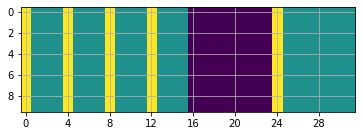

In [17]:
plot_beatmap(unique_beats[280])

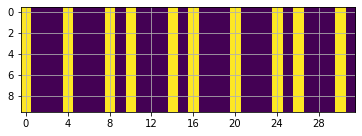

In [12]:
plot_beatmap(unique_beats[326])

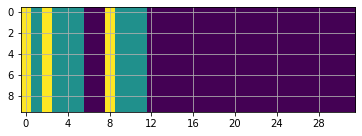

In [13]:
plot_beatmap(unique_beats[404])